In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from xai import read_data, create_dataframe, plot_true_fake_maps, compare_experiments, plot_r_vs_k
#from xai import read_data, create_dataframe, plot_true_fake_maps

from correlation_coefficient import compute_r

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [11]:
base_output_dir = "../output/" # Meanwhile I have my own output directory with GAN results
names = ['test', 'xai_exp_only_using_ha', 'xai_exp_only_using_oiii' ]
results_dir = "../output/xai_results/"
nrun = 100
nindex = 1
suffix_list = [ "run{:d}_index{:d}".format(i, j) for i in range(nrun) for j in range(nindex) ]
ref_dir = os.path.join(base_output_dir, names[0])
ha_dir = os.path.join(base_output_dir, names[1])
oiii_dir = os.path.join(base_output_dir, names[2])

suffix=f"run80_index0"

In [12]:
data_ref = read_data(ref_dir, suffix=suffix, ldict=True)
data_ha = read_data(ha_dir, xai_exp='ha', suffix=suffix, ldict=True)
data_oiii = read_data(oiii_dir, xai_exp='oiii', suffix=suffix, ldict=True)

ha
oiii


Saved plot ../output/xai_results//compare_test_and_only_using_halpha.png


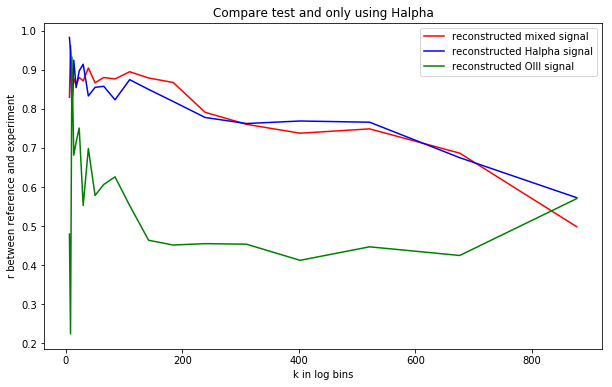

In [15]:
plot_r_vs_k(data_ref, data_ha, results_dir, title="Compare test and only using Halpha")

Saved plot ../output/xai_results//compare_test_and_only_using_oiii.png


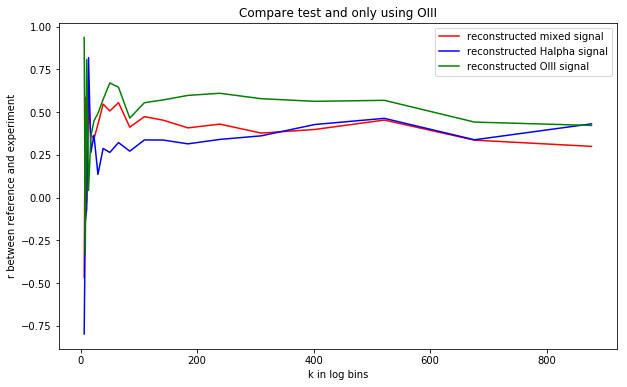

In [14]:
plot_r_vs_k(data_ref, data_oiii, results_dir, title="Compare test and only using OIII")

In [16]:
data_ref = read_data(ref_dir, suffix=suffix, ldict=False)
data_ha = read_data(ha_dir, xai_exp='ha', suffix=suffix, ldict=False)
data_oiii = read_data(oiii_dir, xai_exp='oiii', suffix=suffix, ldict=False)

ha
oiii


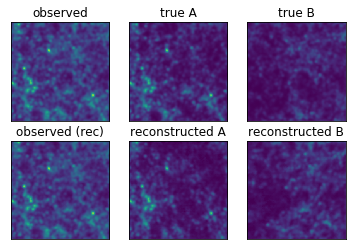

In [17]:
plot_true_fake_maps(data_ref, results_dir)

In [ ]:
plot_true_fake_maps(data_ha, results_dir)

In [ ]:
plot_true_fake_maps(data_oiii, results_dir)

In [ ]:
plot_true_fake_maps(data_random, results_dir)

In [ ]:
    container = {}
    for d in names:
        output_dir = os.path.join(base_output_dir, d)
        if not os.path.exists(output_dir):
            print(f"Output directory {output_dir} does not exist.")
            print("The ouput directory stores the output of the GAN needed as input for XAI.")
            exit()
        df, k = create_dataframe(output_dir, nrun, nindex)
        container[d] = df

In [ ]:
k

In [ ]:
container['test']

In [ ]:
ref = container['test']

In [ ]:
ref.sort_values(by="r_mix_6",ascending=False)